## Подключаем необходимые модули

In [27]:
# !pip install tensorflow_addons

In [28]:
# !git clone https://github.com/lyftzeigen/SemanticSegmentationLesson.git

In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow_addons as tfa

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.12.0
GPU is OFF


## Подготовим набор данных для обучения

In [2]:
CLASSES = 4

COLORS = ['red', 'lime',
          'blue', 'black']

# (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)

SAMPLE_SIZE = (512, 512)

OUTPUT_SIZE = (512, 512)

In [3]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

Переименновка

In [32]:
# import os 

# list_dir = ['./img', 
#             './masks_machine']
# # new_list_dir = ['./new_img', './new_masks']
# name_file = ['i', 'm']


# for i in range(len(list_dir)):
#     for temp, f in enumerate(os.listdir(f"{list_dir[i]}")):
#         os.rename(f"{list_dir[i]}/{f}", f"{list_dir[i]}/{name_file[i]}{temp}.{f[-3:]}")

In [4]:
# images = sorted(glob.glob('./img/*.JPG'))
# masks = sorted(glob.glob('./masks/*.png'))

images = sorted(glob.glob('C:/Users/mi28d/Desktop/ds0_003/img/*.JPG'))
masks = sorted(glob.glob('C:/Users/mi28d/Desktop/ds0_003/masks_machine/*.png'))

# images = sorted(glob.glob('./test_img/test_vis/img/*.JPG'))
# masks = sorted(glob.glob('./test_img/test_vis/masks/*.png'))

# for i in range(len(masks)):
#     print(f"{images[i]=}  {masks[i]=}") 
print(len(images))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

7


## Посмотрим на содержимое набора данных

In [34]:
# images_and_masks = list(dataset.take(1))
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 15), dpi=125)
# image, masks = images_and_masks
# ax[0, 0].set_title('Image')
# ax[0, 0].set_axis_off()
# ax[0, 0].imshow(image)

# ax[0, 0].set_title('Mask')
# ax[0, 0].set_axis_off()    
# ax[0, 0].imshow(image/1.5)

# for channel in range(CLASSES):

      
        
#         contours = measure.find_contours(np.array(masks[:,:,channel]))
#         # print(f"{channel=}    {count=}    {len(contours)=}")
#         for contour in contours:
#             # иттеация по меткам 
#             ax[0, 1].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

# plt.show()
# plt.close()

<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
channel=0    count=1    len(contours)=2
channel=1    count=2    len(contours)=0
channel=2    count=3    len(contours)=0
channel=3    count=4    len(contours)=0
channel=0    count=1    len(contours)=2
channel=1    count=2    len(contours)=0
channel=2    count=3    len(contours)=0
channel=3    count=4    len(contours)=0
channel=0    count=1    len(contours)=7
channel=1    count=2    len(contours)=0
channel=2    count=3    len(contours)=0
channel=3    count=4    len(contours)=0
channel=0    count=1    len(contours)=6
channel=1    count=2    len(contours)=0
channel=2    count=3    len(contours)=0
channel=3    count=4    len(contours)=0
channel=0    count=1    len(contours)=14
channel=1    count=2    len(contours)=0
channel=2    count=3    len(contours)=0
channel=3    count=4    len(contours)=0


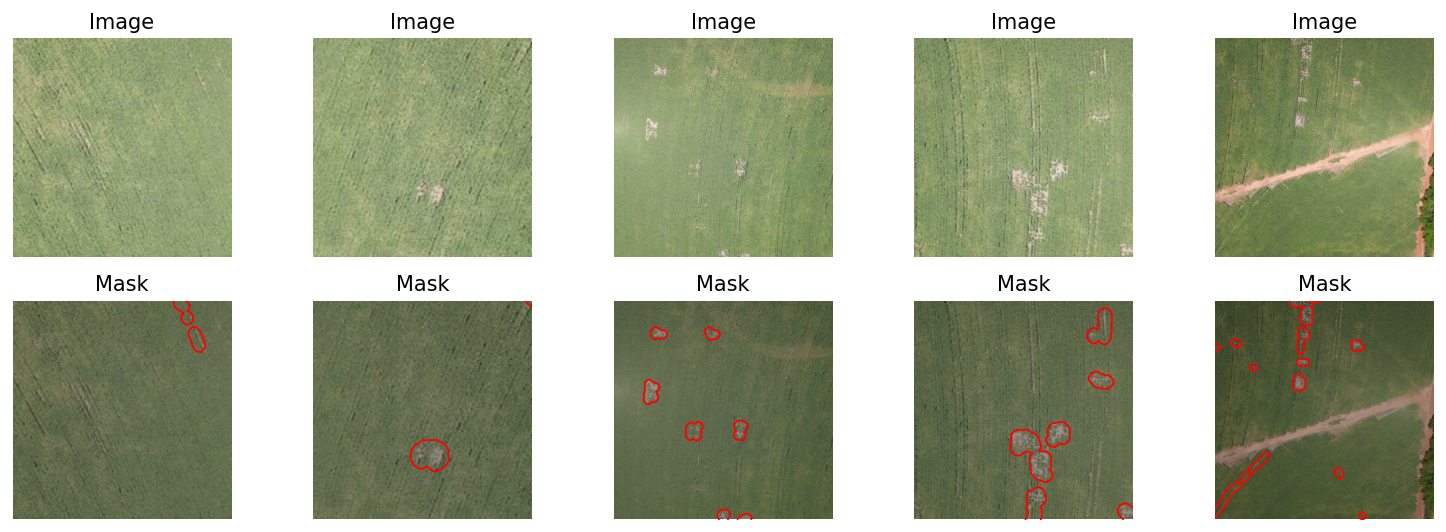

In [5]:
images_and_masks = list(dataset.take(5))
# images_and_masks = list(dataset.take(3))
print(type(dataset))
# images_and_masks = list(dataset.get_single_element(49))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 5), dpi=125)
# fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    # иттерация по выбранным элементам 
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    count = 0

    # for channel in range(CLASSES-2):
    for channel in range(CLASSES):

        count += 1
        
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        print(f"{channel=}    {count=}    {len(contours)=}")
        for contour in contours:
            # иттеация по меткам 
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])
            # ax[1, i].fill(contour[:, 1], contour[:, 0], color=COLORS[channel], alpha=1)
    # print("----------------------")
    # print(count)
    # print(f"{contours=}")
plt.show()
plt.close()

## Разделим набор данных на обучающий и проверочный

In [6]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()
 
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

## Обозначим основные блоки модели

In [7]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Построим U-NET подобную архитектуру

In [8]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Определим метрики и функции потерь

In [9]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

## Компилируем модель

In [10]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [11]:
batch = 12
# unet_like.load_weights('./unet_w_4')
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=10, initial_epoch=0)

from keras.callbacks import ModelCheckpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint.best_checkpoint = unet_like
# callbacks_list = [checkpoint]

unet_like.save_weights('./unet_w_lit_5')
unet_like.save("my_model_lit_5")

# with open("model_chek.txt", "w") as f:
    # f.write(checkpoint)



Epoch 1/10
27/27 [==============================] - 465s 17s/step - loss: 0.4365 - dice_mc_metric: 0.2241
Epoch 2/10
27/27 [==============================] - 451s 17s/step - loss: 0.2540 - dice_mc_metric: 0.2454
Epoch 3/10
27/27 [==============================] - 448s 17s/step - loss: 0.2473 - dice_mc_metric: 0.2447
Epoch 4/10
27/27 [==============================] - 448s 17s/step - loss: 0.2444 - dice_mc_metric: 0.2449
Epoch 5/10
27/27 [==============================] - 449s 17s/step - loss: 0.2399 - dice_mc_metric: 0.2458
Epoch 6/10
27/27 [==============================] - 482s 18s/step - loss: 0.2361 - dice_mc_metric: 0.2468
Epoch 7/10
27/27 [==============================] - 475s 18s/step - loss: 0.2332 - dice_mc_metric: 0.2479
Epoch 8/10
27/27 [==============================] - 462s 17s/step - loss: 0.2320 - dice_mc_metric: 0.2485
Epoch 9/10
27/27 [==============================] - 423s 16s/step - loss: 0.2308 - dice_mc_metric: 0.2493
Epoch 10/10
27/27 [===========================

INFO:tensorflow:Assets written to: my_model_lit_5\assets


INFO:tensorflow:Assets written to: my_model_lit_5\assets


In [45]:
# with open("model_chek.txt", "w") as f:
#     f.write(checkpoint)

unet_like.save_weights('./unet_w_4')
unet_like.save("my_model_3")

INFO:tensorflow:Assets written to: my_model_3\assets


INFO:tensorflow:Assets written to: my_model_3\assets


## Загрузим модель

In [43]:
unet_like.load_weights('./unet_w_4')

## Проверим работу сети на всех кадрах из видео

In [12]:
# TODO: По совершенно не понятной причине, эта параша не хочет находить какие-то объекты, кроме 1 
# то есть => у нас сейчас почему -то как будт-то нейронка хочет работать только с 2-мя классами 

rgb_colors = [
    # (255, 0,   0),
    # (0,   255, 0),
    # (0,   0,   255),
    # (255, 165, 0),
    
    (255, 0, 0), 
    (0, 255, 0), 
    (0, 0, 255), 
    (255, 255, 255),
]

# ['red', 'lime',
#           'blue', 'orange']

frames = sorted(glob.glob('./test_img/img/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(0, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except Exception as e:
            print(f"{e}----{channel=}----{rgb_colors[channel]=}")

    imsave(f'./test_img/predict/{os.path.basename(filename)}', frame)

1/1 [==============================] - 1s 599ms/step
list index out of range----channel=1----rgb_colors[channel]=(0, 255, 0)
list index out of range----channel=2----rgb_colors[channel]=(0, 0, 255)
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 255)
1/1 [==============================] - 0s 284ms/step
list index out of range----channel=1----rgb_colors[channel]=(0, 255, 0)
list index out of range----channel=2----rgb_colors[channel]=(0, 0, 255)
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 255)
